/home/ri/miniconda3/envs/dl/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Batch 1:
Sat Patches Shape: torch.Size([373, 3, 128, 128])
Map Patches Shape: torch.Size([373, 128, 128])


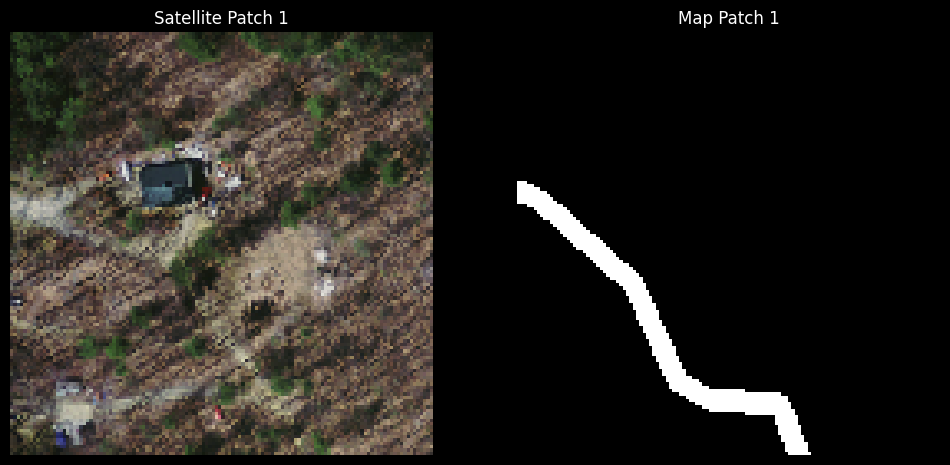

Batch 2:
Sat Patches Shape: torch.Size([515, 3, 128, 128])
Map Patches Shape: torch.Size([515, 128, 128])


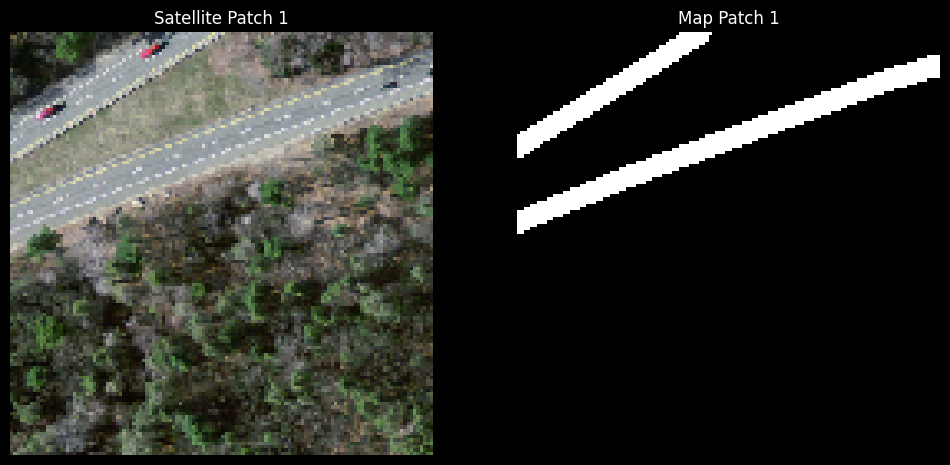

Batch 3:
Sat Patches Shape: torch.Size([379, 3, 128, 128])
Map Patches Shape: torch.Size([379, 128, 128])


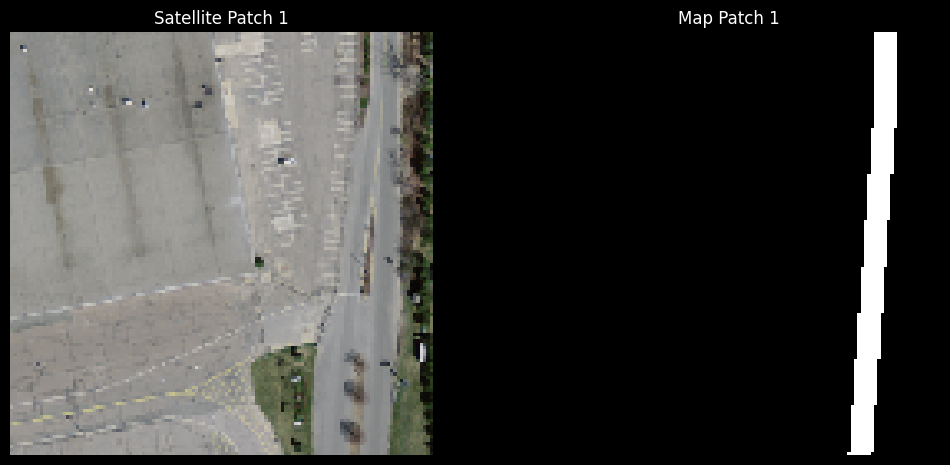

Batch 4:
Sat Patches Shape: torch.Size([144, 3, 128, 128])
Map Patches Shape: torch.Size([144, 128, 128])


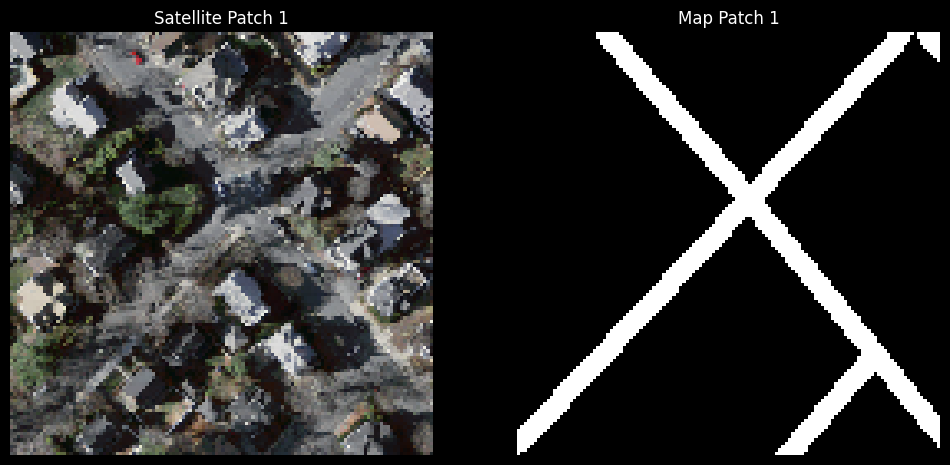

In [ ]:
from torch.utils.data import DataLoader
from dataloaders.mass_roads_dataloader import MassRoadsDataset, custom_collate_fn
import matplotlib.pyplot as plt


data_dir = '/home/ri/Desktop/Projects/Datasets/Mass_Roads/dataset/'

train_dataset = MassRoadsDataset(root_dir=data_dir, split='train', window_size=128, stride=64)#, max_images=200)
test_dataset = MassRoadsDataset(root_dir=data_dir, split='test', window_size=128, stride=64)#, max_images=20)

dataloader_train = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=custom_collate_fn, pin_memory=True)
dataloader_test = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=custom_collate_fn, pin_memory=True)

def plot_patches(sat_patches, map_patches, n_patches=1):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    for i in range(min(n_patches, sat_patches.shape[0])):
        sat_patch = sat_patches[i].numpy().transpose(1, 2, 0) 
        map_patch = map_patches[i].numpy()

        ax[0].imshow(sat_patch)
        ax[0].set_title(f'Satellite Patch {i+1}')
        ax[0].axis('off')

        ax[1].imshow(map_patch, cmap='gray')
        ax[1].set_title(f'Map Patch {i+1}')
        ax[1].axis('off')

    plt.show()

for i, (sat_patches, map_patches) in enumerate(dataloader_train):
    print(f"Batch {i+1}:")
    print(f"Sat Patches Shape: {sat_patches.shape}")
    print(f"Map Patches Shape: {map_patches.shape}")

    plot_patches(sat_patches, map_patches, n_patches=1)
    if i > 2:
        break


In [2]:
from rasterio.errors import NotGeoreferencedWarning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=NotGeoreferencedWarning)


In [4]:
import os
import torch
import torch.optim as optim
from models.MULDE.models import MLPs, ScoreOrLogDensityNetwork
from torchvision import models
import torch.nn as nn
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
checkpoint_path = "./checkpoints/mulde_checkpoint.pth"


class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
    
    def forward(self, pred, target):
        pred = torch.sigmoid(pred)
        smooth = 1.0
        intersection = (pred * target).sum()
        union = pred.sum() + target.sum()
        dice = (2. * intersection + smooth) / (union + smooth)
        return 1 - dice

class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss()
        self.mse_loss = nn.MSELoss()

    def forward(self, pred, target):
        bce = self.bce_loss(pred, target)
        mse = self.mse_loss(torch.sigmoid(pred), target)  # Apply sigmoid to logits before MSE
        return bce + 0.5 * mse  # Adjust weight of MSE as needed

class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
    
    def forward(self, pred, target):
        pred = torch.sigmoid(pred)
        smooth = 1.0
        intersection = (pred * target).sum()
        union = pred.sum() + target.sum()
        dice = (2. * intersection + smooth) / (union + smooth)
        return 1 - dice

class CombinedLoss(nn.Module):
    def __init__(self):
        super(CombinedLoss, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss()
        self.dice_loss = DiceLoss()

    def forward(self, pred, target):
        bce = self.bce_loss(pred, target)
        dice = self.dice_loss(pred, target)
        return bce + dice

class CombinedLossWithMSE(nn.Module):
    def __init__(self):
        super(CombinedLossWithMSE, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss()
        self.dice_loss = DiceLoss()
        self.mse_loss = nn.MSELoss()

    def forward(self, pred, target):
        bce = self.bce_loss(pred, target)
        dice = self.dice_loss(pred, target)
        mse = self.mse_loss(torch.sigmoid(pred), target)  # Apply sigmoid to logits before MSE
        return bce + dice + 0.5 * mse  # Weight MSE appropriately


mlp_model = MLPs(input_dim=2048, output_dim=128*128, units=[4096, 4096])  # Change output_dim to H*W (128x128)
mulde_model = ScoreOrLogDensityNetwork(mlp_model, score_network=False)  # Using log-density network
mulde_model = mulde_model.to(device)

# Load pretrained ResNet50 and freeze the layers
resnet = models.resnet50(pretrained=True)
for param in resnet.parameters():
    param.requires_grad = False
resnet.fc = nn.Identity()  # Remove the final classification layer
resnet = resnet.to(device)

# Define the loss function and optimizer
criterion = CombinedLossWithMSE()  # Use the custom loss function combining BCE, Dice, and MSE
criterion = criterion.to(device)  # Move loss function to the same device as the model
optimizer = optim.Adam(mulde_model.parameters(), lr=1e-5)  # Adam optimizer

# Load checkpoint if it exists
start_epoch = 0
best_loss = float('inf')
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=True)
    mulde_model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_loss = checkpoint['best_loss']
    print(f"Resumed training from epoch {start_epoch}, best loss: {best_loss:.4f}")


num_epochs = 300

# Training loop
for epoch in range(start_epoch, num_epochs):
    mulde_model.train()  # Set model to training mode
    running_loss = 0.0

    for i, (sat_patches, map_patches) in tqdm(enumerate(dataloader_train), total=len(dataloader_train), desc=f"Epoch {epoch+1}/{num_epochs}"):
        if sat_patches.size(0) == 0 or map_patches.size(0) == 0:
            # print(f"Skipping empty batch at index {i}")
            continue  # Skip the empty batch
        
        sat_patches = sat_patches.float().to(device)  # (batch_size, 3, H, W)
        map_patches = map_patches.float().to(device)  # (batch_size, H, W) - road map patches
        
        # Ensure the target map patches are of shape (batch_size, 1, H, W)
        map_patches = map_patches.unsqueeze(1)  # Add channel dimension: (batch_size, 1, H, W)

        # Extract features using ResNet (pretrained), and get a feature map of size (batch_size, 2048)
        features = resnet(sat_patches)  # Features shape: (batch_size, 2048)

        # Forward pass through MULDE network (score network or log-density network)
        outputs = mulde_model(features)  # Output shape: (batch_size, H*W)

        # Reshape the output to match the target shape: (batch_size, 1, H, W)
        outputs = outputs.view(-1, 1, 128, 128)  # Reshape to (batch_size, 1, H, W)

        # Calculate loss using the CombinedLossWithMSE
        loss = criterion(outputs, map_patches)
        
        # Zero gradients, perform backward pass, and optimize the model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Average loss for the epoch
    avg_loss = running_loss / len(dataloader_train)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

    # Save the checkpoint
    checkpoint = {
        'model_state_dict': mulde_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'best_loss': best_loss
    }
    torch.save(checkpoint, checkpoint_path)

    # Save the model if it's the best loss so far
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(mulde_model.state_dict(), "mulde_model_best.pth")
        print("Best model saved.")


Resumed training from epoch 131, best loss: inf


Epoch 132/300:   0%|          | 2/554 [00:04<19:11,  2.09s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 536.00 MiB. GPU 0 has a total capacity of 5.66 GiB of which 122.12 MiB is free. Including non-PyTorch memory, this process has 5.28 GiB memory in use. Of the allocated memory 4.52 GiB is allocated by PyTorch, and 657.43 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

/tmp/ipykernel_911754/1339024778.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mulde_model.load_state_dict(torch.load("mulde_model_best.pth", map_location=device))


Loaded the best model for evaluation.


Testing:   0%|          | 0/49 [00:00<?, ?it/s]/home/ri/miniconda3/envs/dl/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


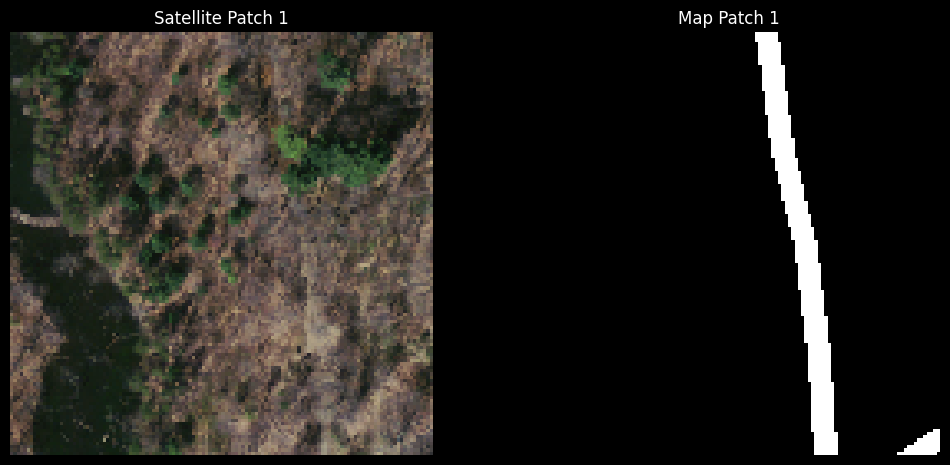

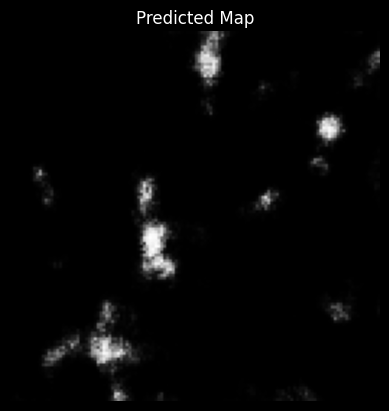

Testing:   2%|▏         | 1/49 [00:02<01:51,  2.32s/it]/home/ri/miniconda3/envs/dl/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


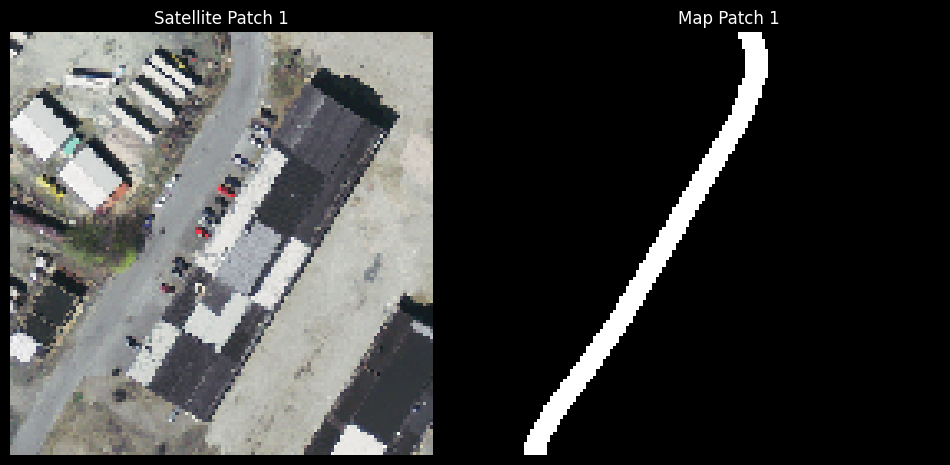

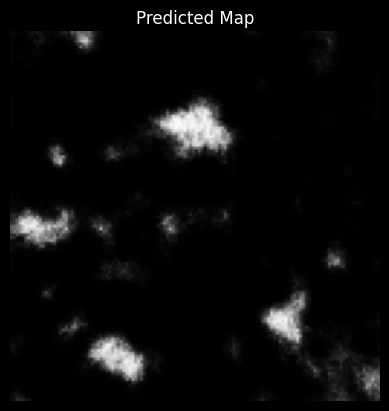

Testing:   4%|▍         | 2/49 [00:07<03:14,  4.13s/it]/home/ri/miniconda3/envs/dl/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


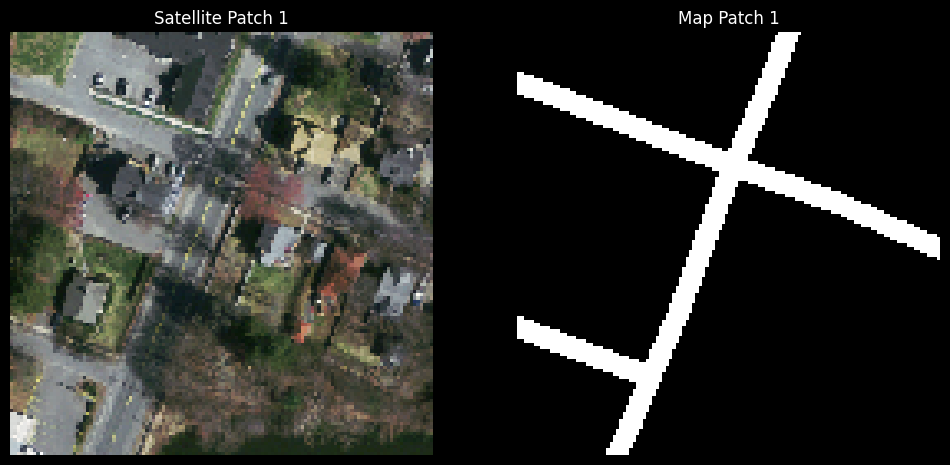

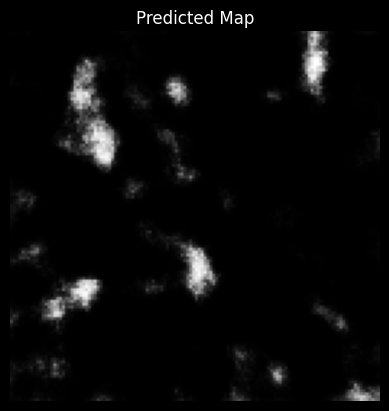

Testing:   6%|▌         | 3/49 [00:15<04:21,  5.68s/it]/home/ri/miniconda3/envs/dl/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Testing:   8%|▊         | 4/49 [00:21<04:26,  5.93s/it]/home/ri/miniconda3/envs/dl/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Testing:  10%|█         | 5/49 [00:24<03:32,  4.82s/it]/home/ri/miniconda3/envs/dl/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Testing:  12%|█▏        | 6/49 [00:27<03:08,  

Average IoU: 0.0423
Average Precision: 0.1226
Average Recall: 0.0693
Average F1 Score: 0.0882


In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
import torch.nn.functional as F

def plot_patches(sat_patches, map_patches, n_patches=1):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    for i in range(min(n_patches, sat_patches.shape[0])):
        sat_patch = sat_patches[i].numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
        map_patch = map_patches[i].numpy().squeeze(0)  # Remove the channel dimension, shape becomes (H, W)

        ax[0].imshow(sat_patch)
        ax[0].set_title(f'Satellite Patch {i+1}')
        ax[0].axis('off')

        ax[1].imshow(map_patch, cmap='gray')
        ax[1].set_title(f'Map Patch {i+1}')
        ax[1].axis('off')

    plt.show()

# Function to calculate IoU
def calculate_iou(pred, target):
    pred = (pred > 0.5).int()  # Convert logits to binary predictions
    target = target.int()
    intersection = (pred & target).sum(dim=(1, 2, 3))  # Intersection
    union = (pred | target).sum(dim=(1, 2, 3))  # Union
    iou = intersection.float() / union.float()
    return iou.mean().item()

# Function to calculate precision, recall, and F1 score
def calculate_metrics(pred, target):
    pred = (pred > 0.5).cpu().numpy().flatten()
    target = target.cpu().numpy().flatten()
    precision = precision_score(target, pred, zero_division=1)
    recall = recall_score(target, pred, zero_division=1)
    f1 = f1_score(target, pred, zero_division=1)
    return precision, recall, f1

# Load the best model or checkpoint
load_best_model = True  # Set to False if you want to load the last checkpoint

if load_best_model:
    # Load the best model weights
    if os.path.exists("mulde_model_best.pth"):
        mulde_model.load_state_dict(torch.load("mulde_model_best.pth", map_location=device))
        print("Loaded the best model for evaluation.")
    else:
        print("Best model file not found!")
else:
    # Load the last checkpoint
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        mulde_model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded checkpoint from epoch {checkpoint['epoch'] + 1}")
    else:
        print("Checkpoint file not found!")

# Test loop
mulde_model.eval()  # Set model to evaluation mode
all_iou = []
all_precision = []
all_recall = []
all_f1 = []

with torch.no_grad():  # Disable gradient computation
    for i, (sat_patches, map_patches) in tqdm(enumerate(dataloader_test), total=len(dataloader_test), desc="Testing"):
        sat_patches = sat_patches.float().to(device)  # (batch_size, 3, H, W)
        map_patches = map_patches.float().to(device)  # (batch_size, H, W)
        map_patches = map_patches.unsqueeze(1)  # Add channel dimension: (batch_size, 1, H, W)

        # Extract features using ResNet
        features = resnet(sat_patches)

        # Forward pass through MULDE network
        outputs = mulde_model(features)
        outputs = outputs.view(-1, 1, 128, 128)  # Reshape to (batch_size, 1, H, W)
        outputs = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities

        # Calculate metrics for the batch
        batch_iou = calculate_iou(outputs, map_patches)
        precision, recall, f1 = calculate_metrics(outputs, map_patches)
        
        all_iou.append(batch_iou)
        all_precision.append(precision)
        all_recall.append(recall)
        all_f1.append(f1)

        # Plot a few samples
        if i < 3:  # Plot for the first 3 batches
            plot_patches(sat_patches.cpu(), map_patches.cpu(), n_patches=1)
            predicted_map = outputs[0, 0].cpu().numpy()
            plt.imshow(predicted_map, cmap='gray')
            plt.title("Predicted Map")
            plt.axis('off')
            plt.show()

# Calculate average metrics
avg_iou = np.mean(all_iou)
avg_precision = np.mean(all_precision)
avg_recall = np.mean(all_recall)
avg_f1 = np.mean(all_f1)

print(f"Average IoU: {avg_iou:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1 Score: {avg_f1:.4f}")


In [ ]:
# import torch
# import gc
# gc.collect()
# torch.cuda.empty_cache()
